In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from glob import glob
import random
from sklearn.utils import class_weight

In [2]:
dataset_dir = 'C:/Users/shruj/Projects/Lung Cancer/New folder'

In [3]:
# Parameters
img_height, img_width = 224, 224  # Image dimensions
batch_size = 32
# num_classes will be determined based on actual data

In [4]:
# Data Preprocessing using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values between 0 and 1
    shear_range=0.2,           # Random shear
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Randomly flip images
    validation_split=0.2       # Split 20% of the data for validation
)

In [5]:
# Load training data
train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1036 images belonging to 4 classes.


In [6]:
# Load validation data
val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 258 images belonging to 4 classes.


In [7]:
# Verify the number of classes
print("Detected classes:", train_gen.class_indices)
num_classes = len(train_gen.class_indices)
print(f"Number of classes: {num_classes}")

Detected classes: {'Stage I - Normal cases': 0, 'Stage II - Bengin cases': 1, 'Stage III - Test cases': 2, 'Stage IV - Malignant cases': 3}
Number of classes: 4


In [8]:
# Modify class labels if necessary (optional)
class_labels = list(train_gen.class_indices.keys())  # Reflects the actual categories 
print("Class Labels:", class_labels)

Class Labels: ['Stage I - Normal cases', 'Stage II - Bengin cases', 'Stage III - Test cases', 'Stage IV - Malignant cases']


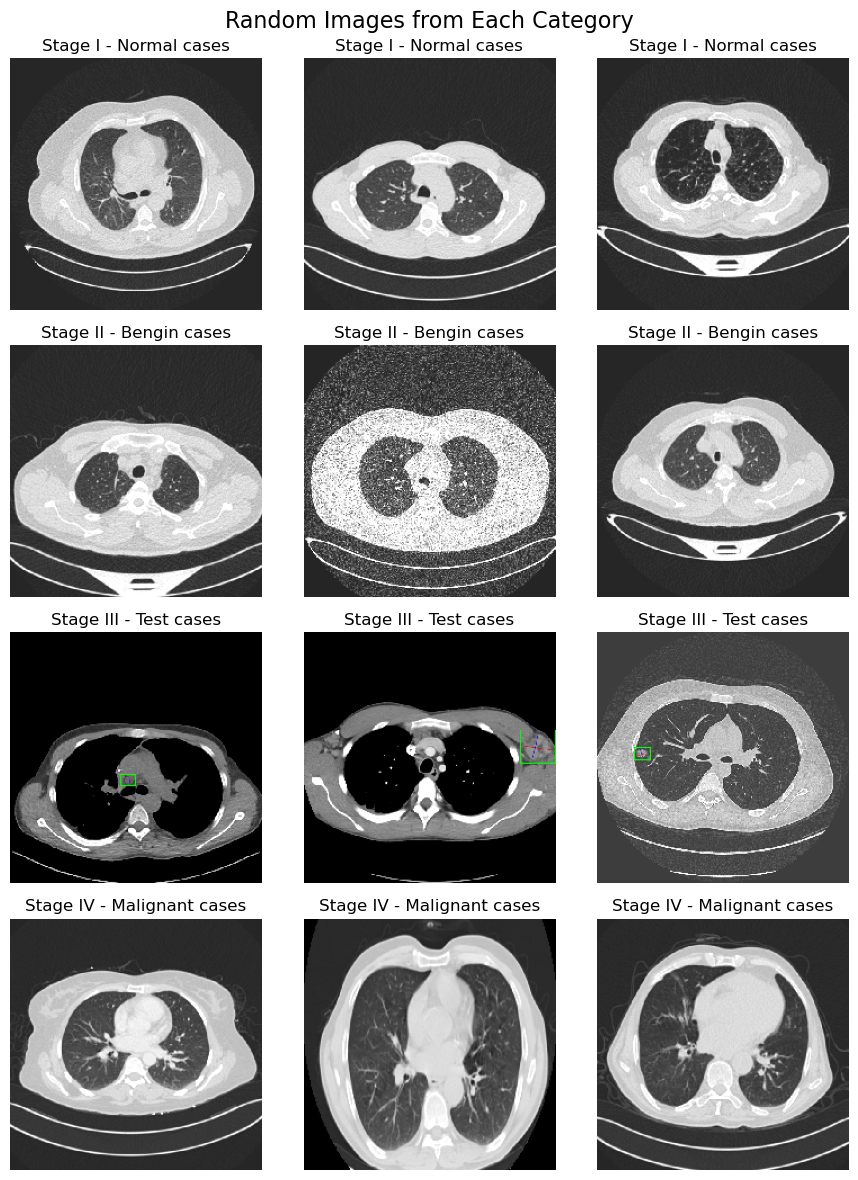

In [9]:
# 1. Visualizing 3 random images from each category

def get_image_paths(category):
    extensions = ['*.jpg', '*.jpeg', '*.png']
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob(os.path.join(dataset_dir, category, ext)))
    return image_paths

def visualize_random_images(train_gen, sample_size=3):
    categories = train_gen.class_indices.keys()
    num_categories = len(categories)
    fig, axs = plt.subplots(nrows=num_categories, ncols=sample_size, figsize=(sample_size*3, num_categories*3))
    
    for i, category in enumerate(categories):
        image_paths = get_image_paths(category)
        available_images = len(image_paths)
        # print(f"Category '{category}' has {available_images} images.")
       
        current_sample_size = min(sample_size, available_images) 
        # if current_sample_size == 0:
        #     print(f"No images found for category '{category}'.")
        #     for j in range(sample_size):
        #         axs[i, j].axis('off')
        #     continue
        
        random_images = random.sample(image_paths, current_sample_size) 
        
        for j, img_path in enumerate(random_images):
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{category}')
        
        for j in range(current_sample_size, sample_size):
            axs[i, j].axis('off')
    
    plt.suptitle("Random Images from Each Category", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call function to visualize random images
visualize_random_images(train_gen)

Number of images per category: {'Stage I - Normal cases': 416, 'Stage II - Bengin cases': 120, 'Stage III - Test cases': 197, 'Stage IV - Malignant cases': 561}


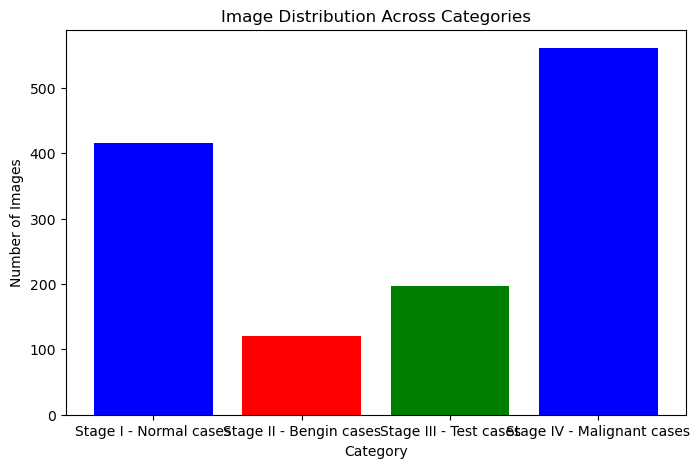

In [10]:
# 2. Creating a bar chart showing the number of images in each stage (Benign, Malignant, Normal)
def plot_category_distribution(train_gen):
    num_images_per_category = {}
    for category in train_gen.class_indices.keys():
        # Consider multiple extensions
        num_images = len(get_image_paths(category))
        num_images_per_category[category] = num_images
    
    print("Number of images per category:", num_images_per_category)
    
    # Plot bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(num_images_per_category.keys(), num_images_per_category.values(), color=['blue', 'red', 'green'])
    plt.title('Image Distribution Across Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

# Call the function to plot distribution
plot_category_distribution(train_gen) 

In [11]:
# Calculate class weights to handle class imbalance
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights_values))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7777777777777778, 1: 2.6979166666666665, 2: 1.639240506329114, 3: 0.576837416481069}


In [12]:
# Define the model architecture
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\shruj\Anaconda_3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    epochs=25,
    class_weight=class_weights  # Apply class weights
)

Epoch 1/25


C:\Users\shruj\Anaconda_3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.2887 - loss: 1.3541 - val_accuracy: 0.1641 - val_loss: 1.3866
Epoch 2/25
 1/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3438 - loss: 1.4466

C:\Users\shruj\Anaconda_3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3438 - loss: 0.7459 - val_accuracy: 0.0000e+00 - val_loss: 0.8515
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3767 - loss: 1.1768 - val_accuracy: 0.4492 - val_loss: 1.1647
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5938 - loss: 0.4537 - val_accuracy: 0.0000e+00 - val_loss: 0.7161
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5248 - loss: 0.9517 - val_accuracy: 0.5156 - val_loss: 1.1548
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7188 - loss: 0.3290 - val_accuracy: 0.5000 - val_loss: 0.3336
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6632 - loss: 0.7624 - val_accuracy: 0.4648 - val_loss: 1.1206
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6250 - loss: 0.3317 - val_accuracy: 1.0000 - val_loss: 0.0942
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6507 - loss: 0.7441 - val_accuracy: 0.5352 - val_loss: 1

In [17]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_gen)
print(f'Validation Accuracy: {val_acc * 100:.2f}%') 

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 735ms/step - accuracy: 0.7104 - loss: 0.9352
Validation Accuracy: 70.54%


In [18]:
# Plot training and validation accuracy/loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

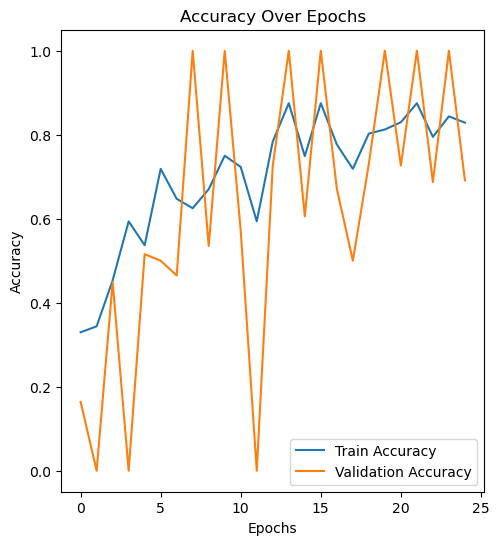

In [19]:
import matplotlib.pyplot as plt
# Accuracy plot
# Plotting accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Over Epochs')

plt.show()

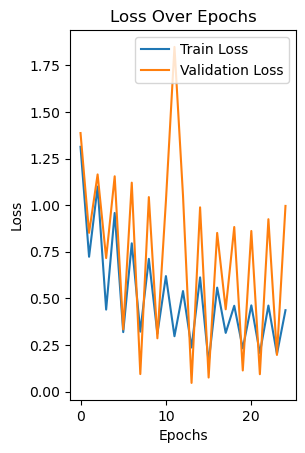

In [20]:
# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Over Epochs')

plt.show() 

In [21]:
# Call the function to plot history
plot_history(history) 

<Figure size 1200x400 with 0 Axes>

In [22]:
# Save the trained model
model.save('lung_cancer_model.keras') 

In [23]:
# This part demonstrates how to use the model for prediction.
# You can load an individual image and make predictions.

from tensorflow.keras.preprocessing import image

def predict_stage(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    # Make prediction
    prediction = model.predict(img_array)
    stage = np.argmax(prediction, axis=1)  # Get class with highest probability
    class_labels = list(train_gen.class_indices.keys())
    return class_labels[stage[0]] 

In [24]:
# Example: Provide the path to an image to predict
# img_path = r'C:\Users\shruj\Projects\Lung Cancer\Malignant cases\Malignant case (3).jpg'
img_path = input("Enter the path of lung cancer image")
predicted_stage = predict_stage(img_path)
print(f'The predicted stage of lung cancer: {predicted_stage}') 

Enter the path of lung cancer image C:\Users\shruj\Projects\Lung Cancer\New folder\Stage II - Bengin cases\Bengin case (10).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
The predicted stage of lung cancer: Stage II - Bengin cases
